In [1]:
#EDA관련 패키지 구성 및 디스플레이 설정
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from IPython.display import set_matplotlib_formats
import warnings
import datetime
import matplotlib.pyplot as pyplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
set_matplotlib_formats('retina')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df_ori = pd.read_csv("./팀_basline_csv.csv")

In [3]:
df=df_ori.copy()

# 데이터파악

In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466 entries, 0 to 1465
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brandnm     1466 non-null   object
 1   goodsnm     1466 non-null   object
 2   USER        1466 non-null   object
 3   reg_date    1466 non-null   object
 4   order_date  1466 non-null   object
 5   p_type      1466 non-null   object
 6   sub_type    1466 non-null   object
 7   app_yn      1466 non-null   object
 8   days        1466 non-null   object
 9   day_type    1466 non-null   object
 10  month       1466 non-null   int64 
 11  How_long    1466 non-null   int64 
dtypes: int64(2), object(10)
memory usage: 137.6+ KB


>**(1).brandnm: 아이템의 브랜드 이름 컬럼 : 범주형 <br>
(2).goodsnm : 아이템의 특성을 담은 이름 컬럼 : 범주형 <br>
(3). USER : 사용자 ID 컬럼 : 범주형 <br>
(4). reg_date : 사용자 가입일 컬럼 : 날짜형 <br>
(5). order_date : 아이템 주문일 컬럼 : 날짜형<br>
(6). p_type : 주문 상품권 종류 5일 7일 : 범주형<br>
(7). sub_type : 주문 아이템 카테고리 : 범주형 <br>
(8). add_yn : 사용자의 어플리케이션 사용 여부 : 범주형**

# STEP2. 잠수고객을 구매고객으로 연결하라!

## 가입후장기간구매가없던고객을 어떻게 구매고객으로 만들까?

## 1. 전환기간에 따른 고객분류

In [6]:
#데이터프레임 생성
df_month=df.copy()
df_month.order_date = pd.to_datetime(df_month.order_date)
df_month.reg_date = pd.to_datetime(df_month.reg_date) 

In [7]:
#전환기간컬럼생성
df_month['trans_period']=(df_month['order_date']-df_month['reg_date']).dt.days

In [8]:
#월별로 데이터 분할
df_month1=df_month[df_month['order_date'].dt.month==1]
df_month2=df_month[df_month['order_date'].dt.month==2]
df_month3=df_month[df_month['order_date'].dt.month==3]

In [9]:
#월별 전환기간 평균, 중앙값 추이
print(df_month1['trans_period'].mean())
print(df_month2['trans_period'].mean())
print(df_month3['trans_period'].mean())
print(df_month1['trans_period'].median())
print(df_month2['trans_period'].median())
print(df_month3['trans_period'].median())

113.88266666666667
89.46799116997792
115.11912225705329
14.0
3.0
3.0


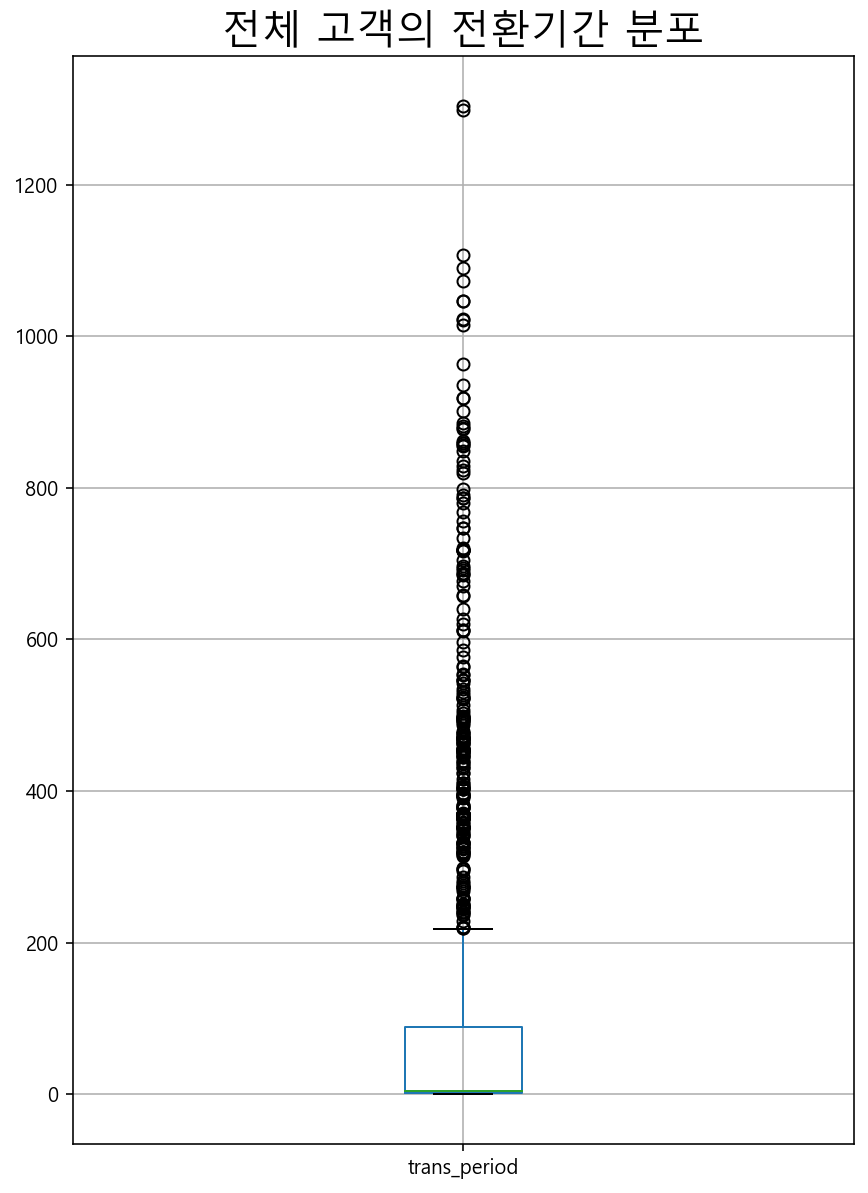

In [69]:
#전체데이터 전환기간 분포
plt.figure(figsize=(7,10))
plt.title('전체 고객의 전환기간 분포',fontsize=20)
boxplot=df_month.boxplot(column='trans_period')
plt.show()

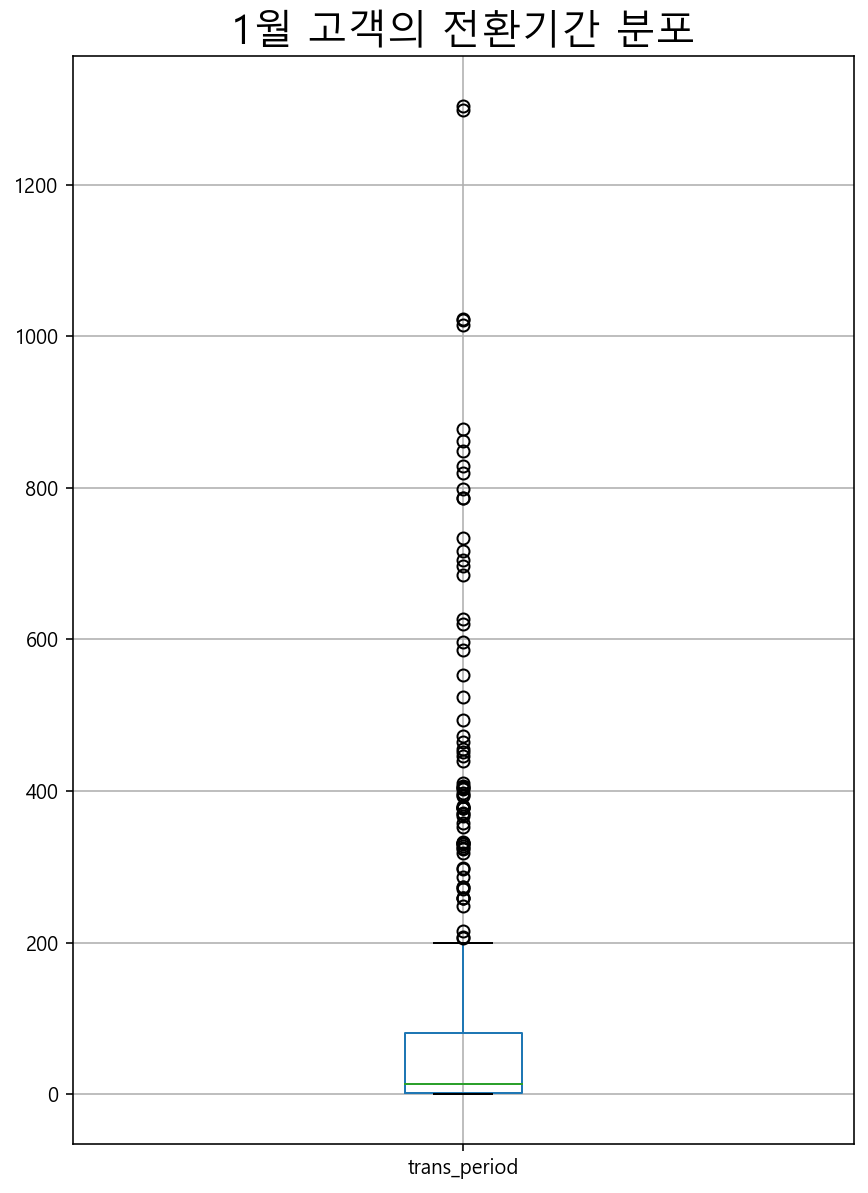

In [70]:
#월별 전환기간 분포(1월)
plt.figure(figsize=(7,10))
plt.title('1월 고객의 전환기간 분포',fontsize=20)
boxplot=df_month1.boxplot(column='trans_period')
plt.show()

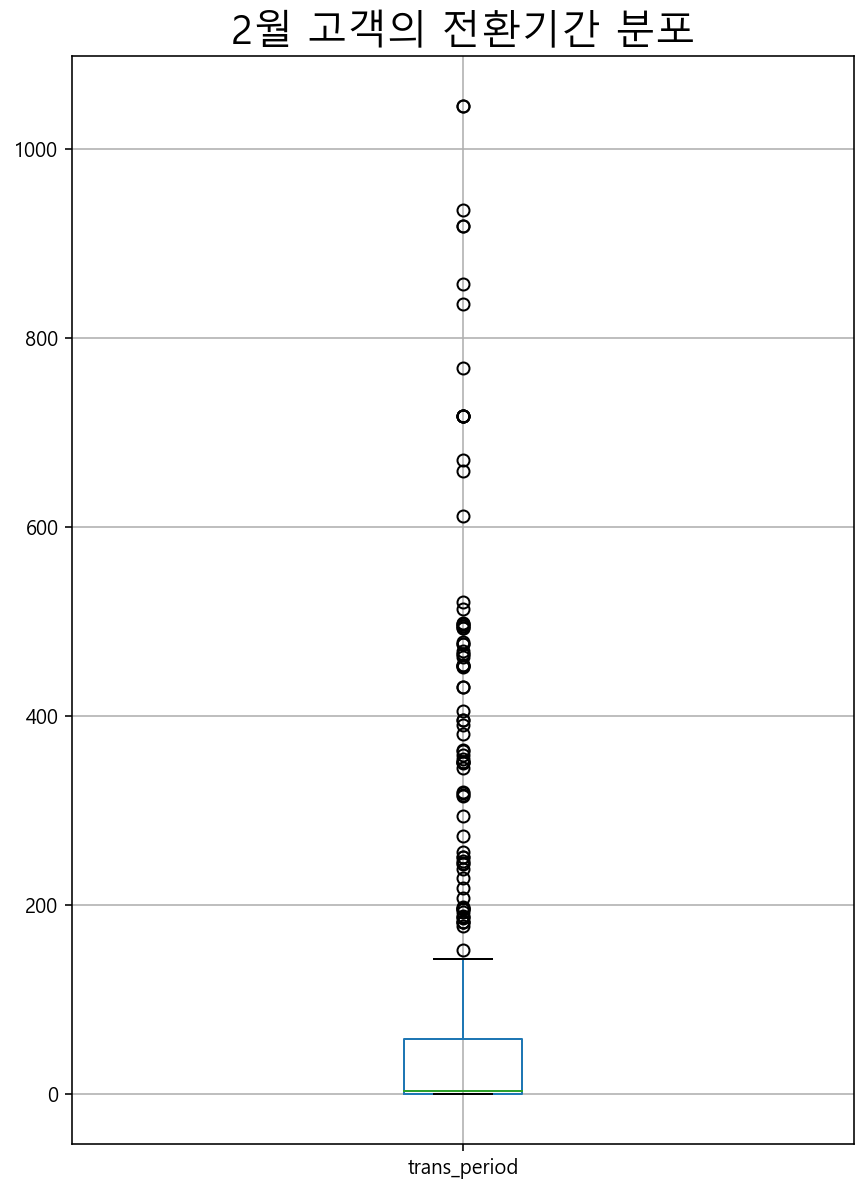

In [71]:
#월별 전환기간 분포(2월)
plt.figure(figsize=(7,10))
plt.title('2월 고객의 전환기간 분포',fontsize=20)
boxplot=df_month2.boxplot(column='trans_period')
plt.show()

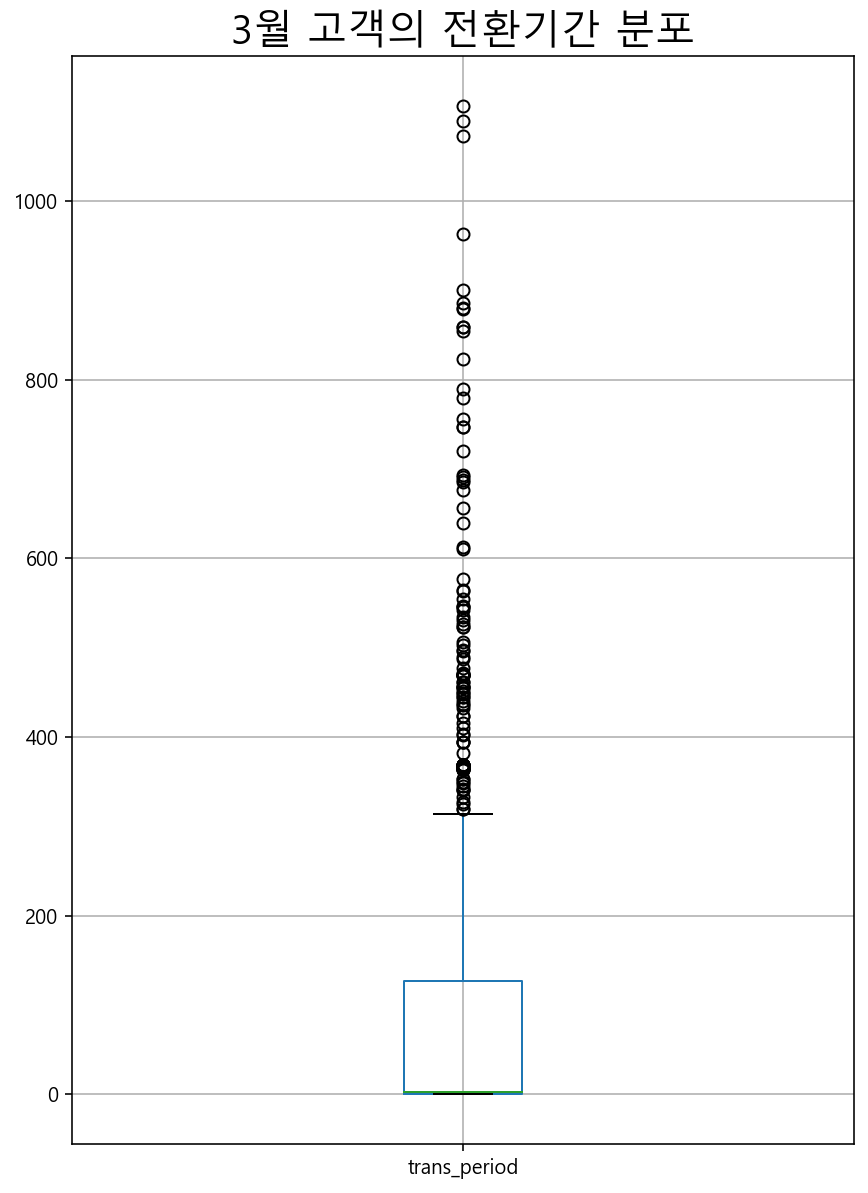

In [72]:
#월별 전환기간 분포(3월)
plt.figure(figsize=(7,10))
plt.title('3월 고객의 전환기간 분포',fontsize=20)
boxplot=df_month3.boxplot(column='trans_period')
plt.show()

>**전환기간 0~3일은 TS등급** <br>
**전환기간 4~200일 TA등급**<br>
**전환기간 200~600일 TB등급**<br>
**전환기간 600일이상 TC등급**<br>

In [16]:
df_ts=df_month[(df_month['trans_period']>=0) & (df_month['trans_period']<=3)]
df_ta=df_month[(df_month['trans_period']>=4) & (df_month['trans_period']<=200)]
df_tb=df_month[(df_month['trans_period']>=201) & (df_month['trans_period']<=600)]
df_tc=df_month[df_month['trans_period']>600]

In [17]:
print(len(df_ts['USER'].unique()))
print(len(df_ta['USER'].unique()))
print(len(df_tb['USER'].unique()))
print(len(df_tc['USER'].unique()))

627
368
178
56


In [18]:
627/(627+368+178+56)

0.5101708706265257

## 2. 각 등급별 기초 탐색

**TS 등급 기초 탐색**

In [19]:
#ts등급의 brandnm 분포 탐색
df_tsb=df_ts['brandnm'].value_counts()
print(df_tsb)

Gucci                 135
Saint Laurent          56
Chanel                 56
Louis Vuitton          50
Prada                  30
                     ... 
Oh L                    1
Reiss                   1
Alice & Olivia          1
Lookast                 1
Calvin Klein Jeans      1
Name: brandnm, Length: 151, dtype: int64


In [20]:
#ts등급 goodsnm 분포 탐색
df_tsg=df_ts['goodsnm'].value_counts()
print(df_tsg.head(15))

chevron quilted cross bag black     16
boy chanel clutch black             11
dionysus cross bag beige             7
classic clutch black                 7
mini sunset chain bag black          6
epi tote bag black                   6
quilted shoulder bag black           6
microssima emily mini bag black      5
padlock GG canvas shoulder bag       5
logo chain tote bag black            4
monogram clutch brown                4
monogram cross body bag black        4
dionysus shoulder bag beige          4
logo pointed cross bag black         4
chevron quilting cross bag cream     4
Name: goodsnm, dtype: int64


In [21]:
#ts등급 USER 컬럼 분포 확인
df_tsu=df_ts['USER'].value_counts()
print('가장 많은 데이터를 가진 고객의 데이터 수는 %d 입니다.' %(df_tsu.max()))
print(df_tsu)

가장 많은 데이터를 가진 고객의 데이터 수는 11 입니다.
a1149461    11
a1149583    10
a1149542     6
a1142679     4
a1146852     4
            ..
a1145612     1
a1149657     1
a1144837     1
a1148370     1
a1149269     1
Name: USER, Length: 627, dtype: int64


In [22]:
#ts등급 p_type 분포 탐색
df_tsp=df_ts['p_type'].value_counts()
print(df_tsp)
326/(383+326)

4days    389
7days    332
Name: p_type, dtype: int64


0.459802538787024

AxesSubplot(0.125,0.125;0.775x0.755)


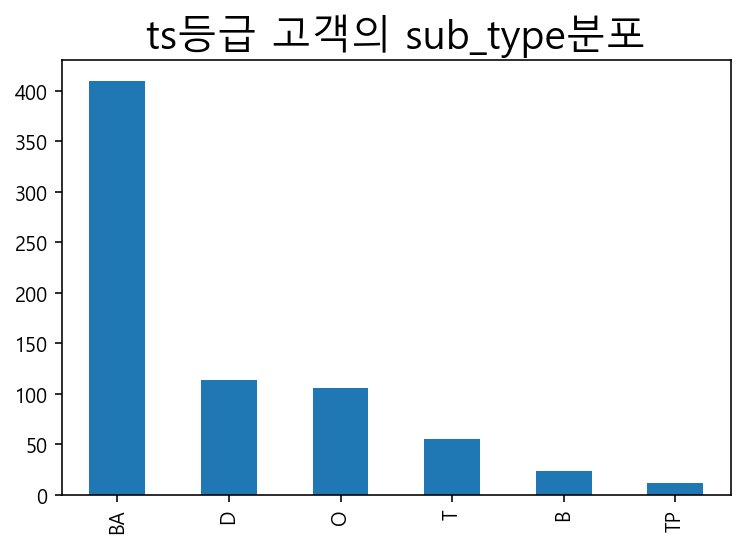

In [73]:
#ts등급 sub_type 분포 탐색
df_tss=df_ts['sub_type'].value_counts().plot(kind='bar')
plt.title('ts등급 고객의 sub_type분포',fontsize=20)
print(df_tss)

In [24]:
#ts등급 app_yn 분포 탐색
df_tsa=df_ts['app_yn'].value_counts()
print(df_tsa)

Y    608
N    113
Name: app_yn, dtype: int64


(1).brandnm: 아이템의 브랜드 이름 컬럼 : 범주형
(2).goodsnm : 아이템의 특성을 담은 이름 컬럼 : 범주형
(3). USER : 사용자 ID 컬럼 : 범주형
(4). reg_date : 사용자 가입일 컬럼 : 날짜형
(5). order_date : 아이템 주문일 컬럼 : 날짜형
(6). p_type : 주문 상품권 종류 5일 7일 : 범주형
(7). sub_type : 주문 아이템 카테고리 : 범주형
(8). add_yn : 사용자의 어플리케이션 사용 여부 : 범주형

**TA등급 기초 탐색**

In [25]:
#ta등급의 brandnm 분포 탐색
df_tab=df_ta['brandnm'].value_counts().head(20)
print(df_tab)

Gucci                 68
Saint Laurent         22
Louis Vuitton         21
Chanel                19
Thom Browne           19
Burberry              19
Prada                 17
Yves Saint Laurent    12
Mixed                 12
Max Mara              10
Dolce & Gabbana        9
Sandro                 9
Celine                 8
Christian Dior         8
Fendi                  6
Jill Stuart            6
Burberry London        6
Mojosphine             5
Maje                   5
It michaa              4
Name: brandnm, dtype: int64


In [26]:
#ta등급 goodsnm 분포 탐색
df_tag=df_ta['goodsnm'].value_counts()
print(df_tag.head(20))

chevron quilted cross bag black                4
slit stripe pattern wool top grey              4
basic pattern H-Line dress black               3
monogram clutch brown                          3
super mini sylvie white                        3
luggage bag black                              3
mammont chain wallet bag black                 3
flap cross bag black                           3
dionysus shoulder bag beige                    3
flap cross bag grey                            3
button stripe pattern wool cardigan black      3
mamont chain bag black                         3
button stripe pattern cashmere sweater grey    2
monogram eva clutch                            2
button stripe pattern shirts white             2
basic pattern A-Line dress cream               2
monogram chain wallet bag black                2
padlock GG canvas shoulder bag                 2
logo hobo bag black                            2
chevron quilted cross bag beige                2
Name: goodsnm, dtype

In [27]:
#ta등급 USER 컬럼 분포 확인
df_tau=df_ta['USER'].value_counts()
print('가장 많은 데이터를 가진 고객의 데이터 수는 %d 입니다.' %(df_tau.max()))
print(df_tau)

가장 많은 데이터를 가진 고객의 데이터 수는 9 입니다.
a1142677    9
a1143701    7
a1129550    6
a1140758    5
a1146366    4
           ..
a1136274    1
a1135283    1
a1143565    1
a1148022    1
a1138863    1
Name: USER, Length: 368, dtype: int64


In [28]:
#ta등급 p_type 분포 탐색
df_tap=df_ta['p_type'].value_counts()
print(df_tap)
140/(310+140)

4days    319
7days    143
Name: p_type, dtype: int64


0.3111111111111111

AxesSubplot(0.125,0.125;0.775x0.755)


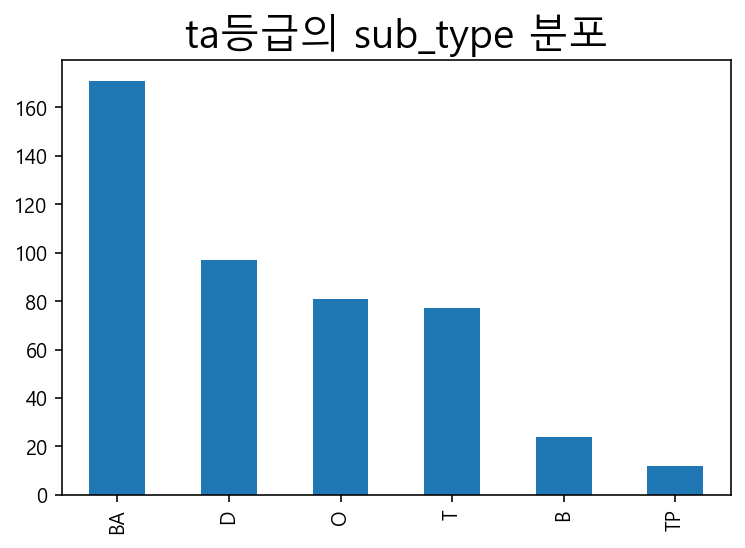

In [74]:
#Ta그룹 sub_type 컬럼 분포 확인
df_tas=df_ta['sub_type'].value_counts().plot(kind='bar')
plt.title('ta등급의 sub_type 분포',fontsize=20)
print(df_tas)

In [31]:
#ta등급 app_yn 사용여부 분포 탐색
df_taa=df_ta['app_yn'].value_counts()
print(df_taa)

Y    424
N     38
Name: app_yn, dtype: int64


**TB등급 기초 탐색**

In [32]:
#ta등급의 선호 브랜드 분포 탐색
df_tbb=df_tb['brandnm'].value_counts()
print(df_tbb)

Gucci         25
Chanel        15
Burberry      12
Prada          8
Max Mara       7
              ..
Maje           1
Beaker         1
Balenciaga     1
Cos            1
Etro           1
Name: brandnm, Length: 94, dtype: int64


In [33]:
#ta등급 제품 분포 탐색
df_tbg=df_tb['goodsnm'].value_counts()
print(df_tbg.head(15))

classic clutch black                       4
belt basic pattern trench-coat beige       4
sylvie leather mini chain bag black        2
patent small beige                         2
basic pattern sweat-shirts grey            2
brooch check pattern H-Line dress ivory    2
two way bucket bag white                   2
serpenti bag green                         2
flower dionysus shoulder bag beige         2
padlock GG canvas shoulder bag             2
quilted chain shoulder bag black           2
button basic pattern coat grey             2
chevron quilted cross bag black            2
marmont gg logo quilted bag Black 2        2
pocket basic pattern slacks navy           2
Name: goodsnm, dtype: int64


In [34]:
#ta등급 결제타입 분포 탐색
df_tbp=df_tb['p_type'].value_counts()
print(df_tbp)
76/(141+76)

4days    143
7days     77
Name: p_type, dtype: int64


0.35023041474654376

AxesSubplot(0.125,0.125;0.775x0.755)


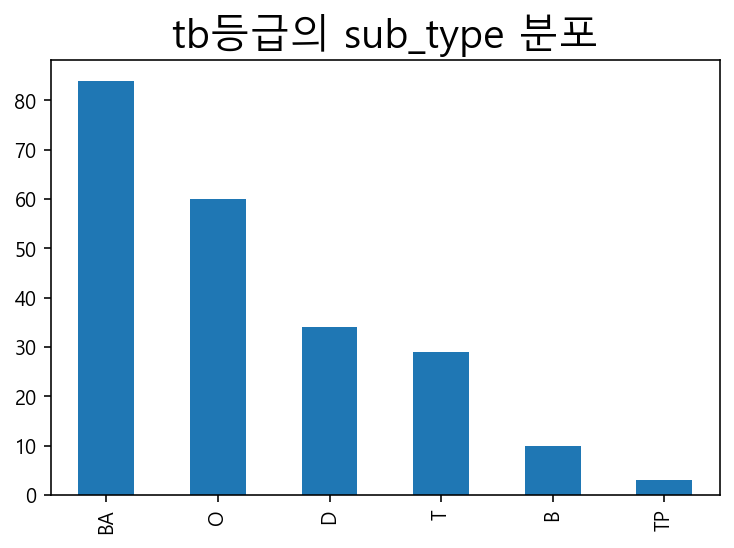

In [75]:
#Tb그룹 아이템카테고리 컬럼 분포 확인
df_tbs=df_tb['sub_type'].value_counts().plot(kind='bar')
plt.title('tb등급의 sub_type 분포',fontsize=20)
print(df_tbs)

In [37]:
#ta등급 어플 사용여부 분포 탐색
df_tba=df_tb['app_yn'].value_counts()
print(df_tba)

Y    201
N     19
Name: app_yn, dtype: int64


**TC등급 기초 탐색**

<AxesSubplot:title={'center':'tc등급의 brandnm 분포'}>

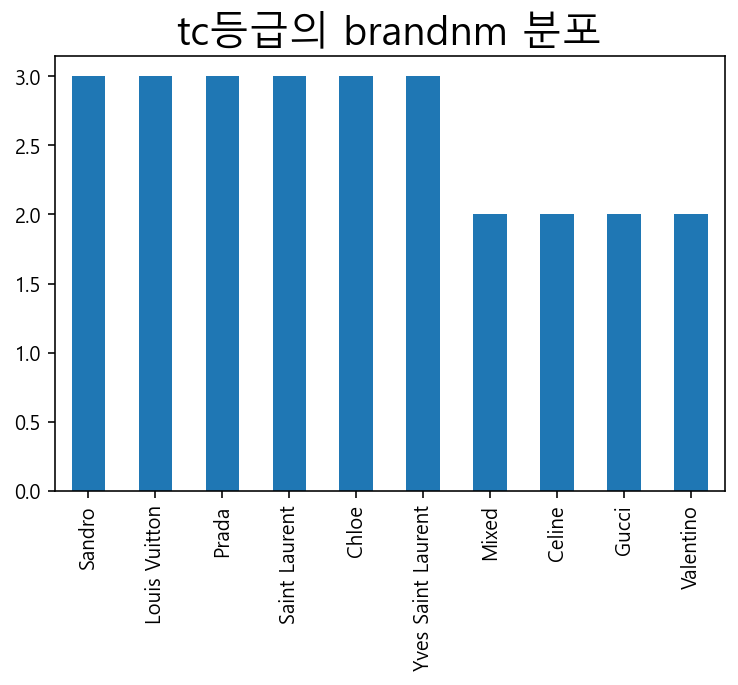

In [76]:
#tc등급 브랜드 선호 분포 탐색
df_tcb=df_tc['brandnm'].value_counts().head(10)
plt.title('tc등급의 brandnm 분포',fontsize=20)
df_tcb.plot(kind='bar')

<AxesSubplot:title={'center':'전체 고객의 brandnm 분포'}>

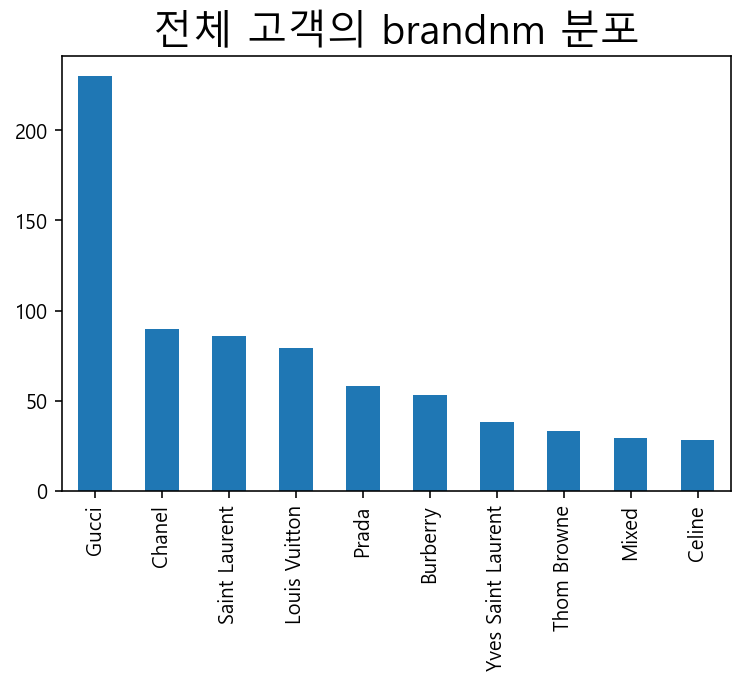

In [77]:
#brandnm 컬럼 분포 확인
df_brandnm=df['brandnm'].value_counts().head(10)
plt.title('전체 고객의 brandnm 분포',fontsize=20)
df_brandnm.plot(kind='bar')

>**Gucci의 압도적인 선호도가 TC그룹에서는 나타나지 않음**<br>
**심지어 Chanel의 경우 상위 선호브랜드에 나타나지 않음**<br>
**TC그룹의 경우 선호브랜드분포가 다른 그룹과 다를 수 있음** 

AxesSubplot(0.125,0.125;0.775x0.755)


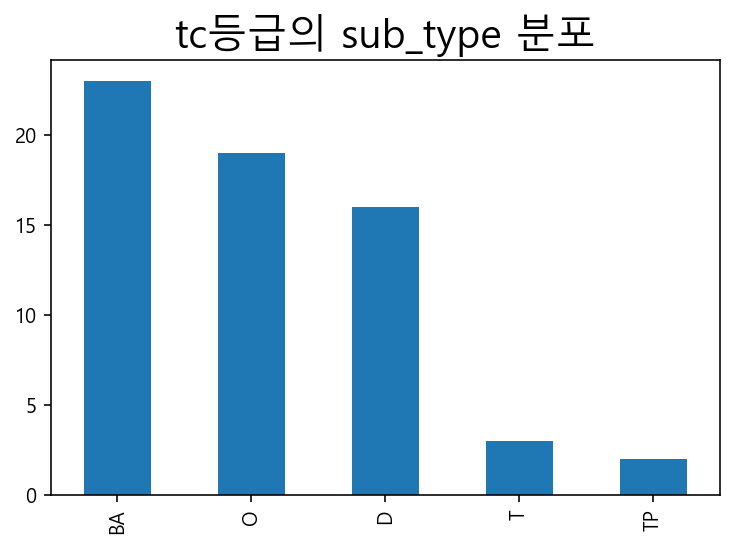

In [78]:
#TC그룹 sub_type 컬럼 분포 확인
df_tcs=df_tc['sub_type'].value_counts().plot(kind='bar')
plt.title('tc등급의 sub_type 분포',fontsize=20)
print(df_tcs)

AxesSubplot(0.125,0.125;0.775x0.755)


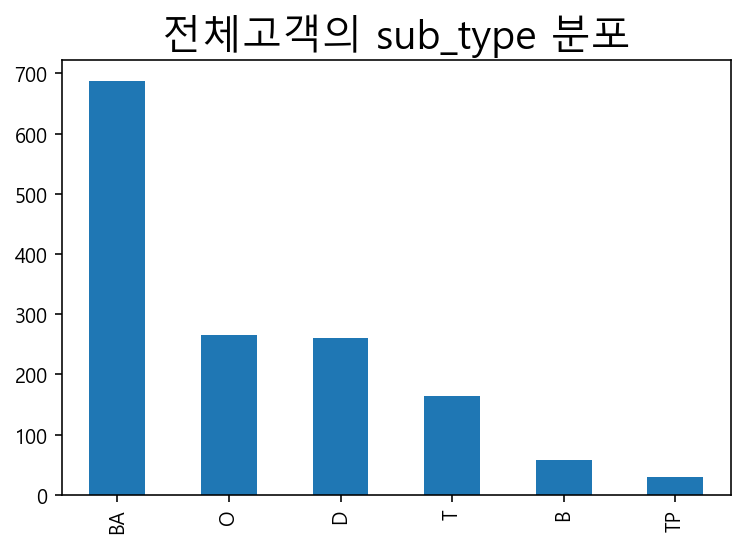

In [79]:
#전체 데이터 sub_type 컬럼 분포 확인
df_subtype=df['sub_type'].value_counts().plot(kind='bar')
plt.title('전체고객의 sub_type 분포',fontsize=20)
print(df_subtype)

>**제품 카테고리 분포는 전체 데이터와 비슷한 것으로 보아 브랜드 범위 측면에서 강화가 필요함**

In [42]:
#tc등급 분포 탐색
df_tca=df_tc['app_yn'].value_counts()
print(df_tca)

Y    59
N     4
Name: app_yn, dtype: int64


In [43]:
#tc등급 결제타입 분포 탐색
df_tcp=df_tc['p_type'].value_counts()
print(df_tcp)

4days    41
7days    22
Name: p_type, dtype: int64


In [44]:
print(563/(874+563))
print(21/(21+40))
print(326/(383+326))

0.3917884481558803
0.3442622950819672
0.459802538787024


>**TC->TS로 갈수록 결제타입이 7days로 변화중**

In [45]:
df_allb2=pd.DataFrame(df['brandnm'].value_counts())
df_allb2.reset_index(inplace=True)
df_allb2['importance']=df_allb2['brandnm']/df_allb2['brandnm'].sum()
df_allb2

,index,brandnm,importance
0,Gucci,230,0.16
1,Chanel,90,0.06
2,Saint Laurent,86,0.06
3,Louis Vuitton,79,0.05
4,Prada,58,0.04
...,...,...,...
240,Spring Crocus,1,0.00
241,MYEYEKO,1,0.00
242,Zadig & Voltaire,1,0.00
243,SJYP,1,0.00


## 3. 각 등급별 brandnm 중요도 변화

<AxesSubplot:title={'center':'전체고객의 brandnm별 중요도'}, xlabel='index', ylabel='importance'>

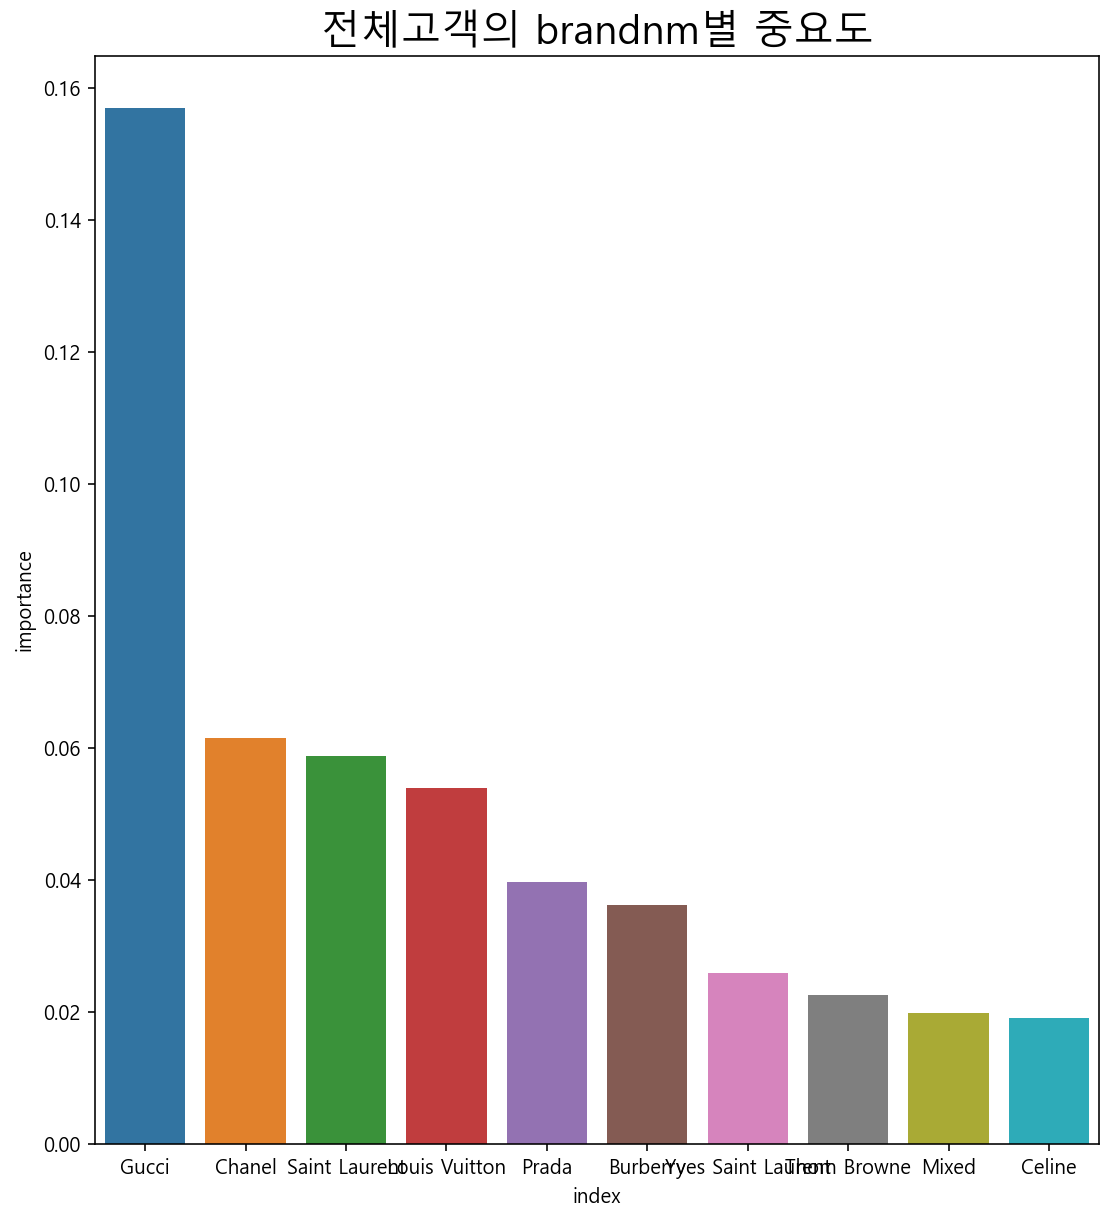

In [57]:
#전체의 brandnm 분포 탐색 심화
df_allb=pd.DataFrame(df['brandnm'].value_counts())
df_allb.reset_index(inplace=True)
df_allb['importance']=df_allb['brandnm']/df_allb['brandnm'].sum()
df_allb=df_allb.sort_values(by='importance',ascending=False).drop('brandnm',axis=1)
df_allb=df_allb.head(10)
fig, ax = pyplot.subplots(figsize=(9,10))
ax.set_title('전체고객의 brandnm별 중요도',fontsize=20)
sns.barplot(data=df_allb,x='index',y= "importance")

<AxesSubplot:title={'center':'ts등급 고객의 brandnm별 중요도'}, xlabel='index', ylabel='importance'>

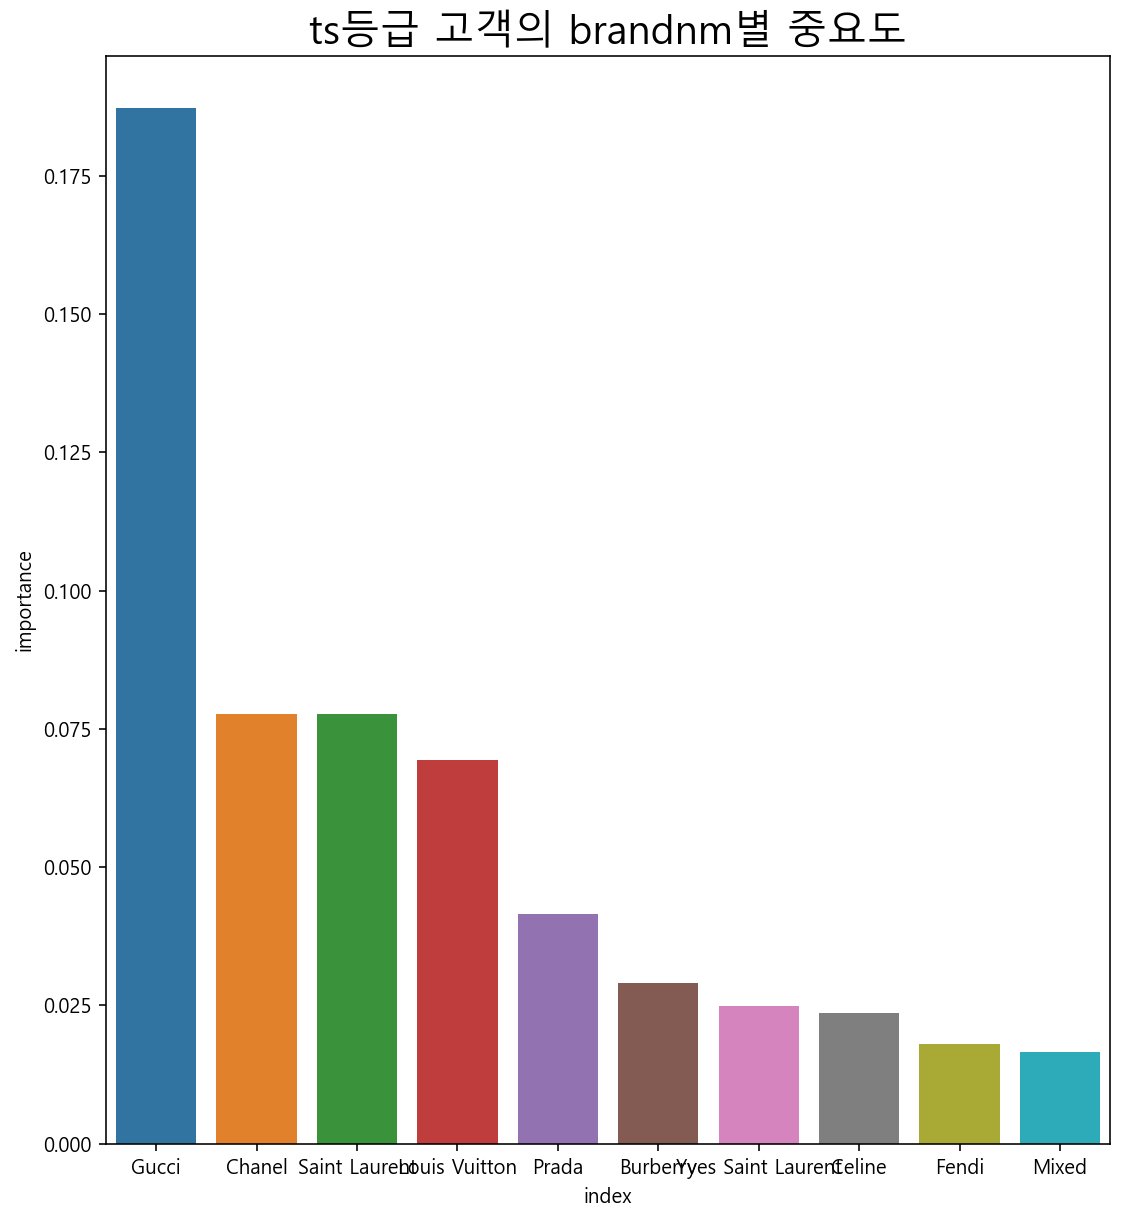

In [58]:
#ts brandnm 분포 탐색 심화
df_ts1=pd.DataFrame(df_ts['brandnm'].value_counts())
df_ts1.reset_index(inplace=True)
df_ts1['importance']=df_ts1['brandnm']/df_ts1['brandnm'].sum()
df_ts1=df_ts1.sort_values(by='importance',ascending=False).drop('brandnm',axis=1)
df_ts1=df_ts1.head(10)
fig, ax = pyplot.subplots(figsize=(9,10))
ax.set_title('ts등급 고객의 brandnm별 중요도',fontsize=20)
sns.barplot(data=df_ts1,x='index',y= "importance")

<AxesSubplot:title={'center':'ta등급 고객의 brandnm별 중요도'}, xlabel='index', ylabel='importance'>

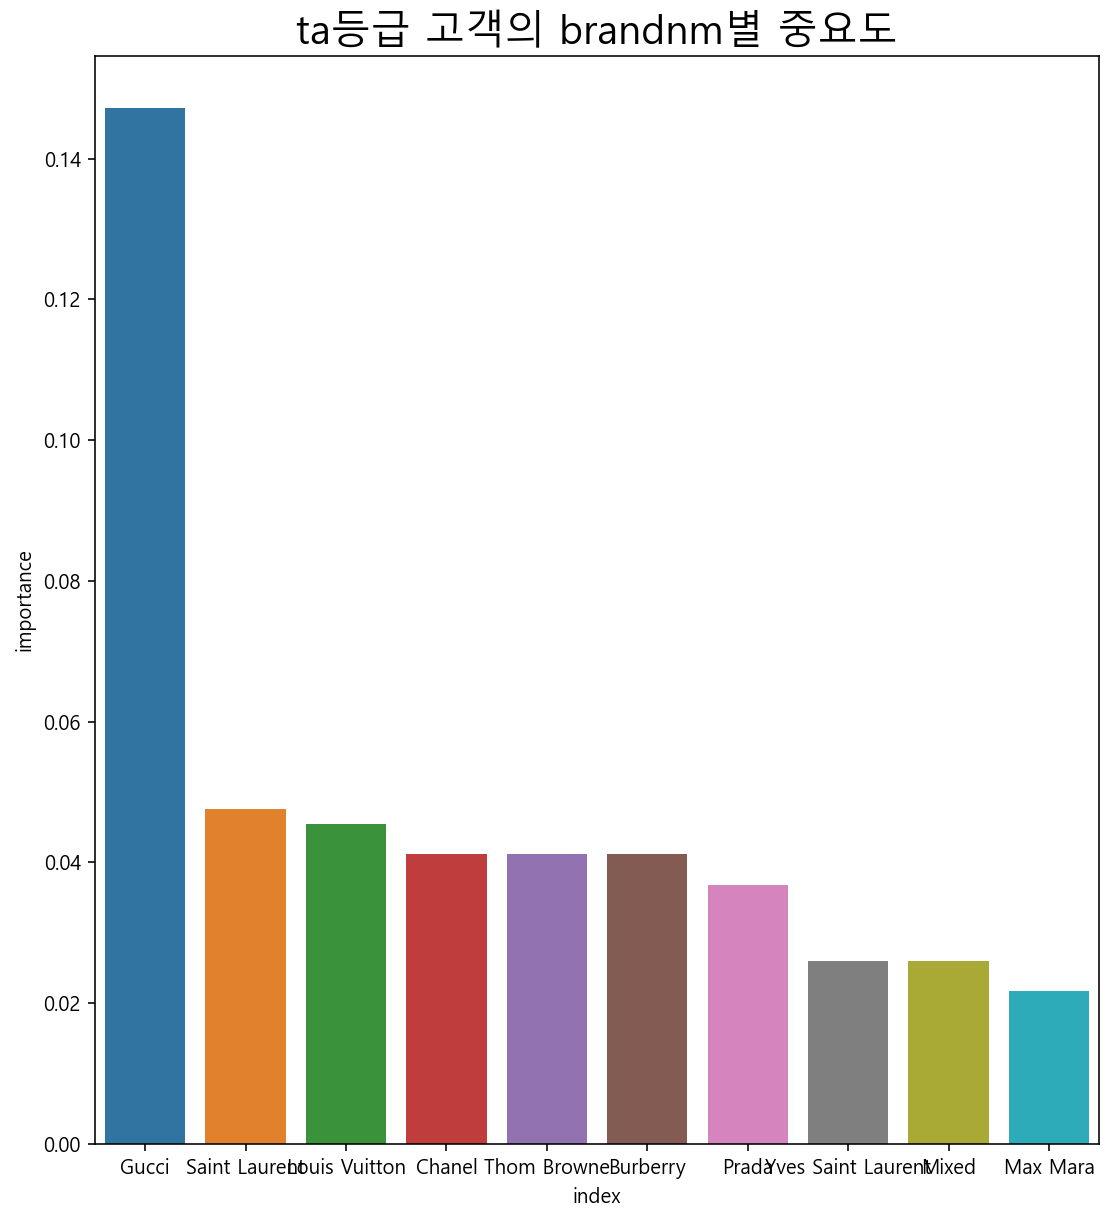

In [59]:
#ta brandnm 분포 탐색 심화
df_ta1=pd.DataFrame(df_ta['brandnm'].value_counts())
df_ta1.reset_index(inplace=True)
df_ta1['importance']=df_ta1['brandnm']/df_ta1['brandnm'].sum()
df_ta1=df_ta1.sort_values(by='importance',ascending=False).drop('brandnm',axis=1)
df_ta1=df_ta1.head(10)
fig, ax = pyplot.subplots(figsize=(9,10))
ax.set_title('ta등급 고객의 brandnm별 중요도',fontsize=20)
sns.barplot(data=df_ta1,x='index',y= "importance")

<AxesSubplot:title={'center':'tb등급 고객의 brandnm별 중요도'}, xlabel='index', ylabel='importance'>

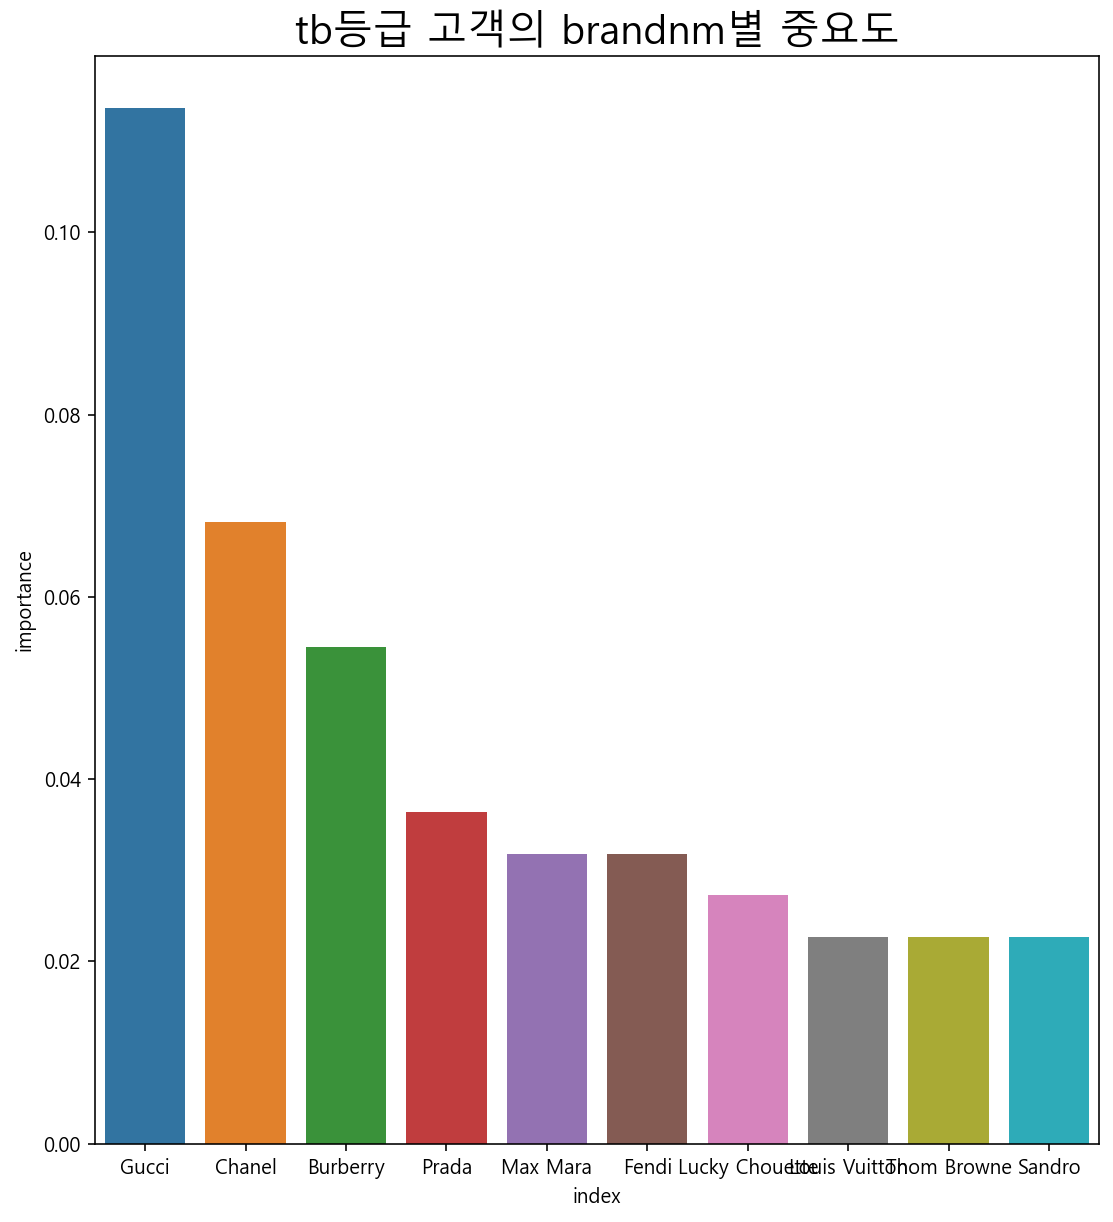

In [60]:
#tb brandnm 분포 탐색 심화
df_tb1=pd.DataFrame(df_tb['brandnm'].value_counts())
df_tb1.reset_index(inplace=True)
df_tb1['importance']=df_tb1['brandnm']/df_tb1['brandnm'].sum()
df_tb1=df_tb1.sort_values(by='importance',ascending=False).drop('brandnm',axis=1)
df_tb1=df_tb1.head(10)
fig, ax = pyplot.subplots(figsize=(9,10))
ax.set_title('tb등급 고객의 brandnm별 중요도',fontsize=20)
sns.barplot(data=df_tb1,x='index',y= "importance")

<AxesSubplot:title={'center':'tc등급 고객의 brandnm별 중요도'}, xlabel='index', ylabel='importance'>

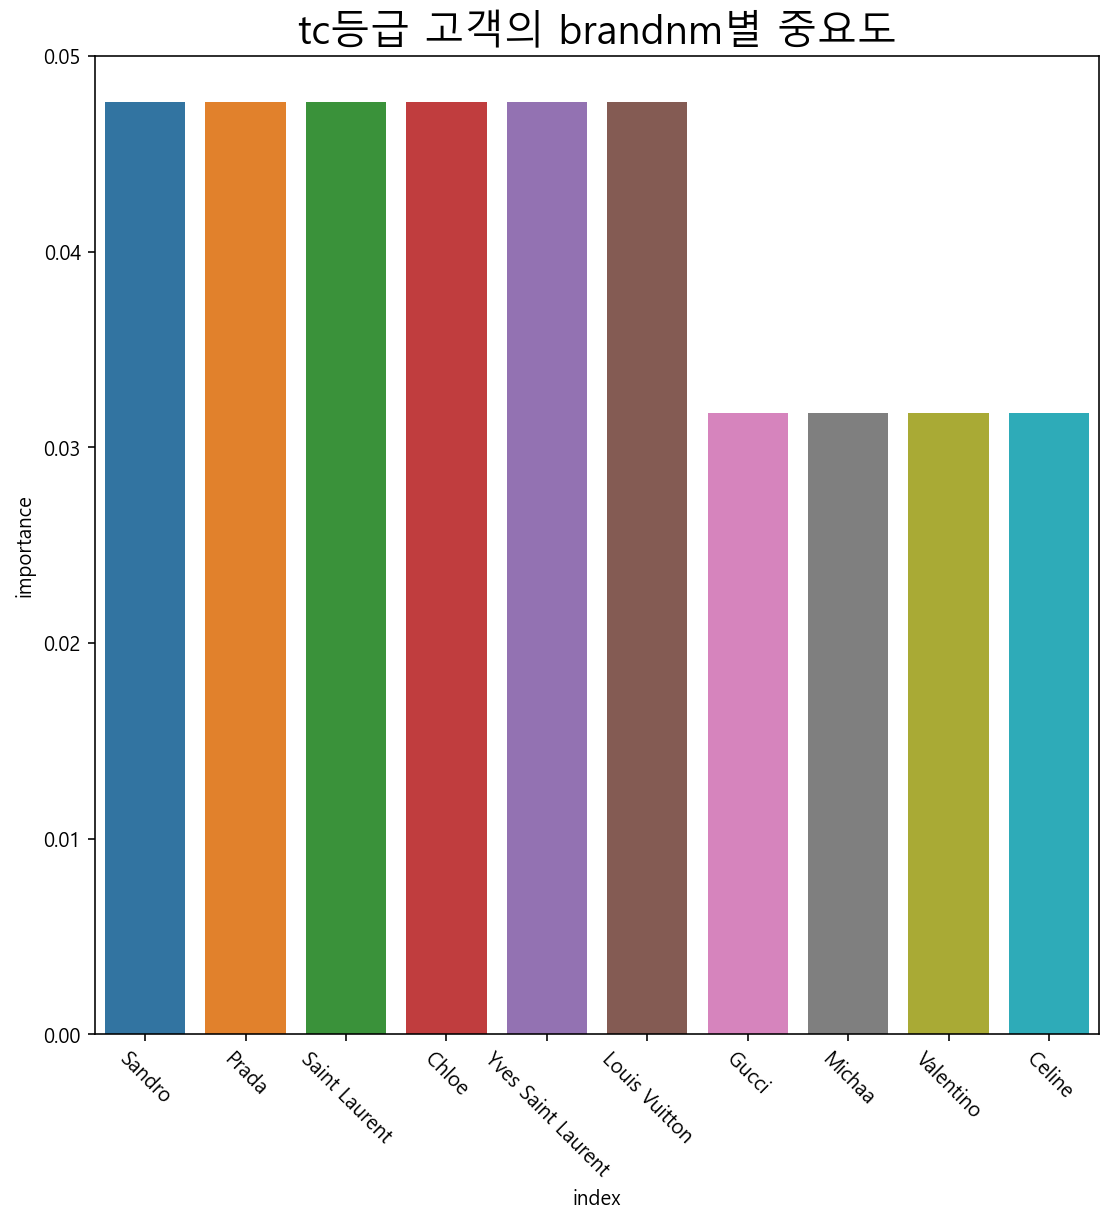

In [61]:
#tc brandnm 분포 탐색 심화
df_tc1=pd.DataFrame(df_tc['brandnm'].value_counts())
df_tc1.reset_index(inplace=True)
df_tc1['importance']=df_tc1['brandnm']/df_tc1['brandnm'].sum()
df_tc1=df_tc1.sort_values(by='importance',ascending=False).drop('brandnm',axis=1)
df_tc1=df_tc1.head(10)
fig, ax = pyplot.subplots(figsize=(9,9))
plt.xticks(rotation = - 45 )
ax.set_title('tc등급 고객의 brandnm별 중요도',fontsize=20)
sns.barplot(data=df_tc1,x='index',y= "importance")

## 4. 각 등급별 goodsnm 중요도 변화

<AxesSubplot:title={'center':'전체 고객의 goodsnm별 중요도'}, xlabel='index', ylabel='importance'>

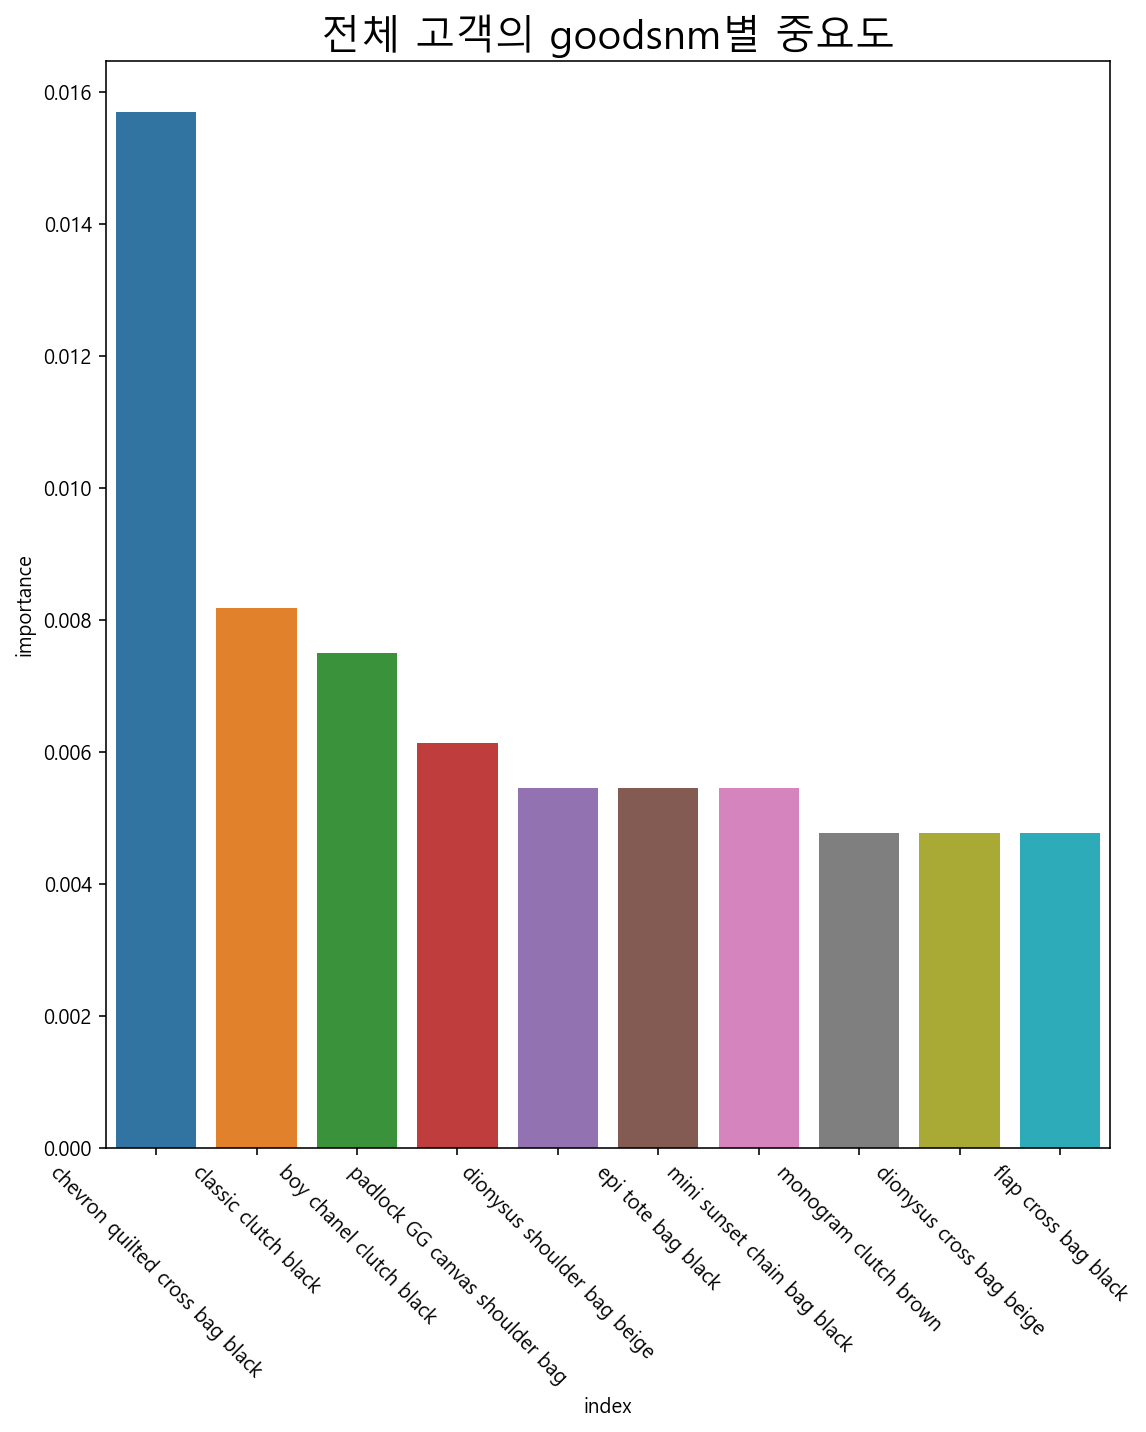

In [62]:
#전체의 goodsnm 분포 탐색 심화
df_allb=pd.DataFrame(df['goodsnm'].value_counts())
df_allb.reset_index(inplace=True)
df_allb['importance']=df_allb['goodsnm']/df_allb['goodsnm'].sum()
df_allb=df_allb.sort_values(by='importance',ascending=False).drop('goodsnm',axis=1)
df_allb=df_allb.head(10)
fig, ax = pyplot.subplots(figsize=(9,10))
plt.xticks(rotation = - 45 )
ax.set_title('전체 고객의 goodsnm별 중요도',fontsize=20)
sns.barplot(data=df_allb,x='index',y= "importance")

<AxesSubplot:title={'center':'ts등급 고객의 goodsnm별 중요도'}, xlabel='index', ylabel='importance'>

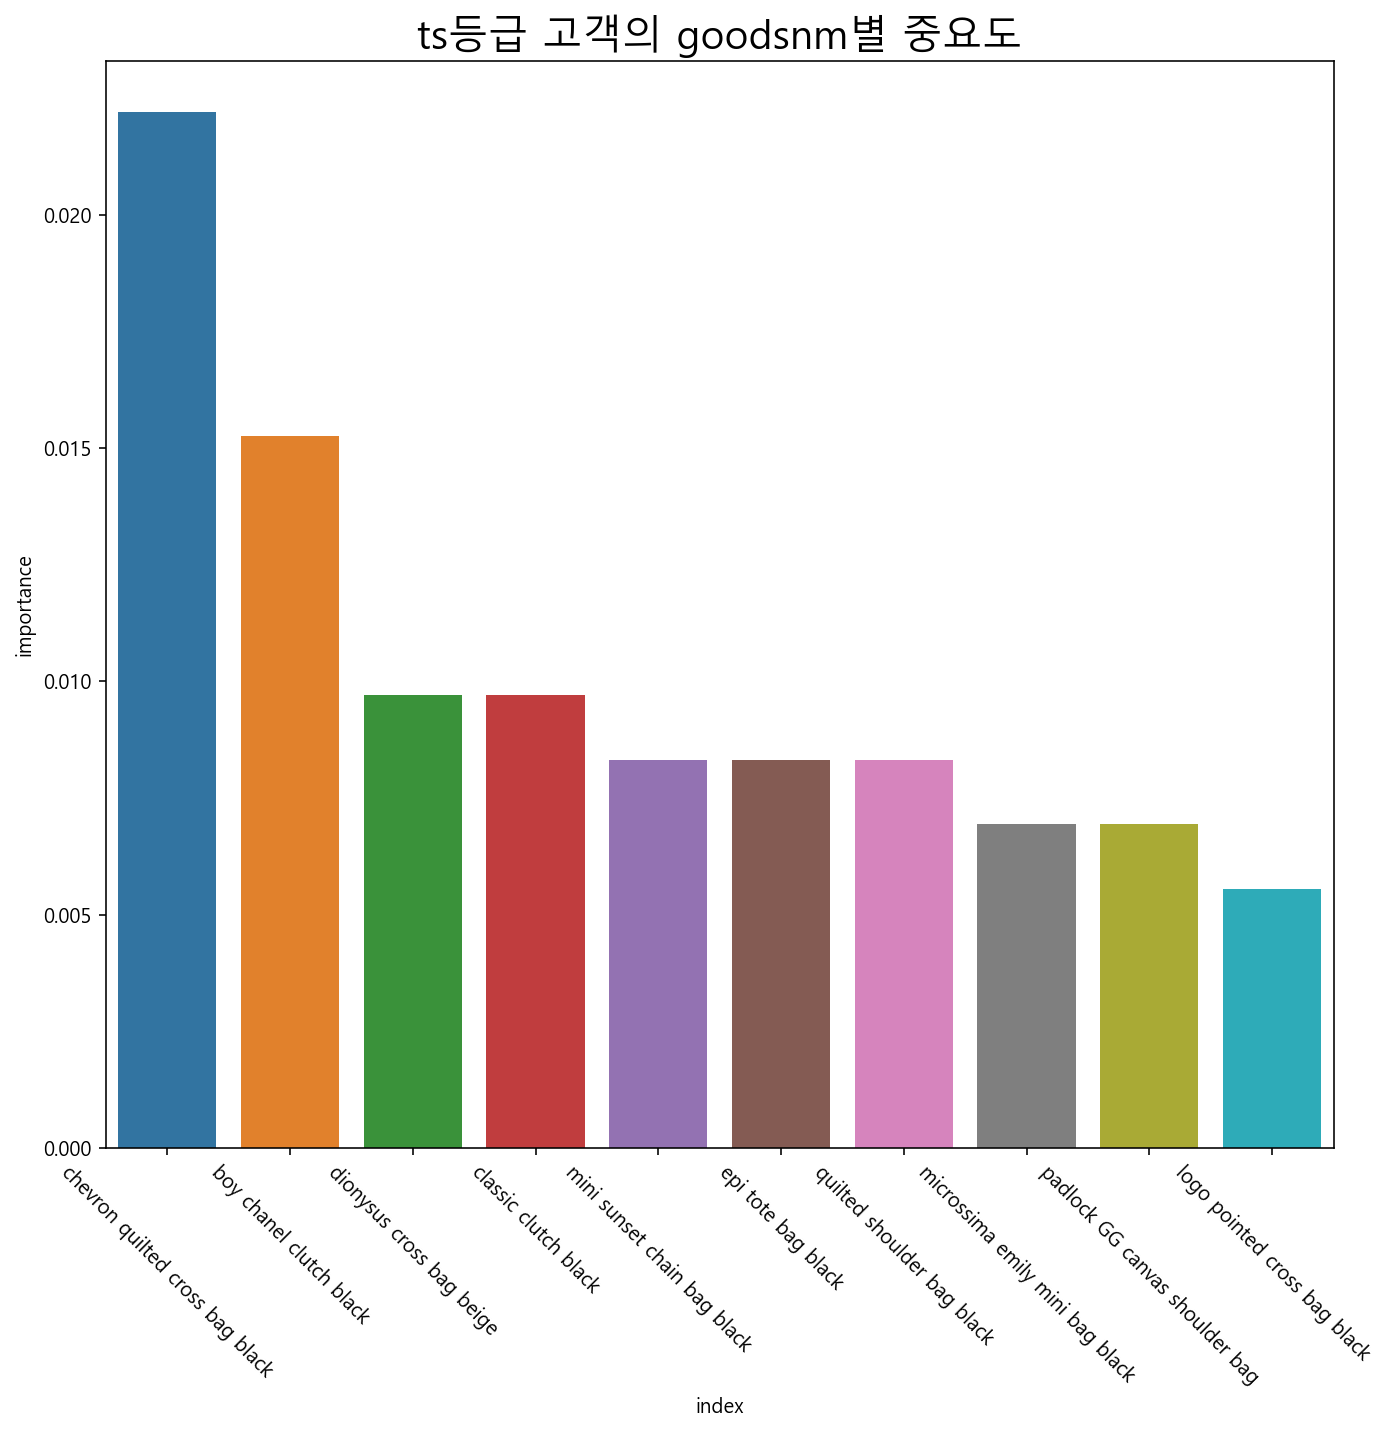

In [68]:
#ts goodsnm 분포 탐색 심화
df_ts2=pd.DataFrame(df_ts['goodsnm'].value_counts())
df_ts2.reset_index(inplace=True)
df_ts2['importance']=df_ts2['goodsnm']/df_ts2['goodsnm'].sum()
df_ts2=df_ts2.sort_values(by='importance',ascending=False).drop('goodsnm',axis=1)
df_ts2=df_ts2.head(10)
fig, ax = pyplot.subplots(figsize=(11,10))
plt.xticks(rotation = - 45 )
ax.set_title('ts등급 고객의 goodsnm별 중요도',fontsize=20)
sns.barplot(data=df_ts2,x='index',y= "importance")

<AxesSubplot:title={'center':'ta등급 고객의 goodsnm별 중요도'}, xlabel='index', ylabel='importance'>

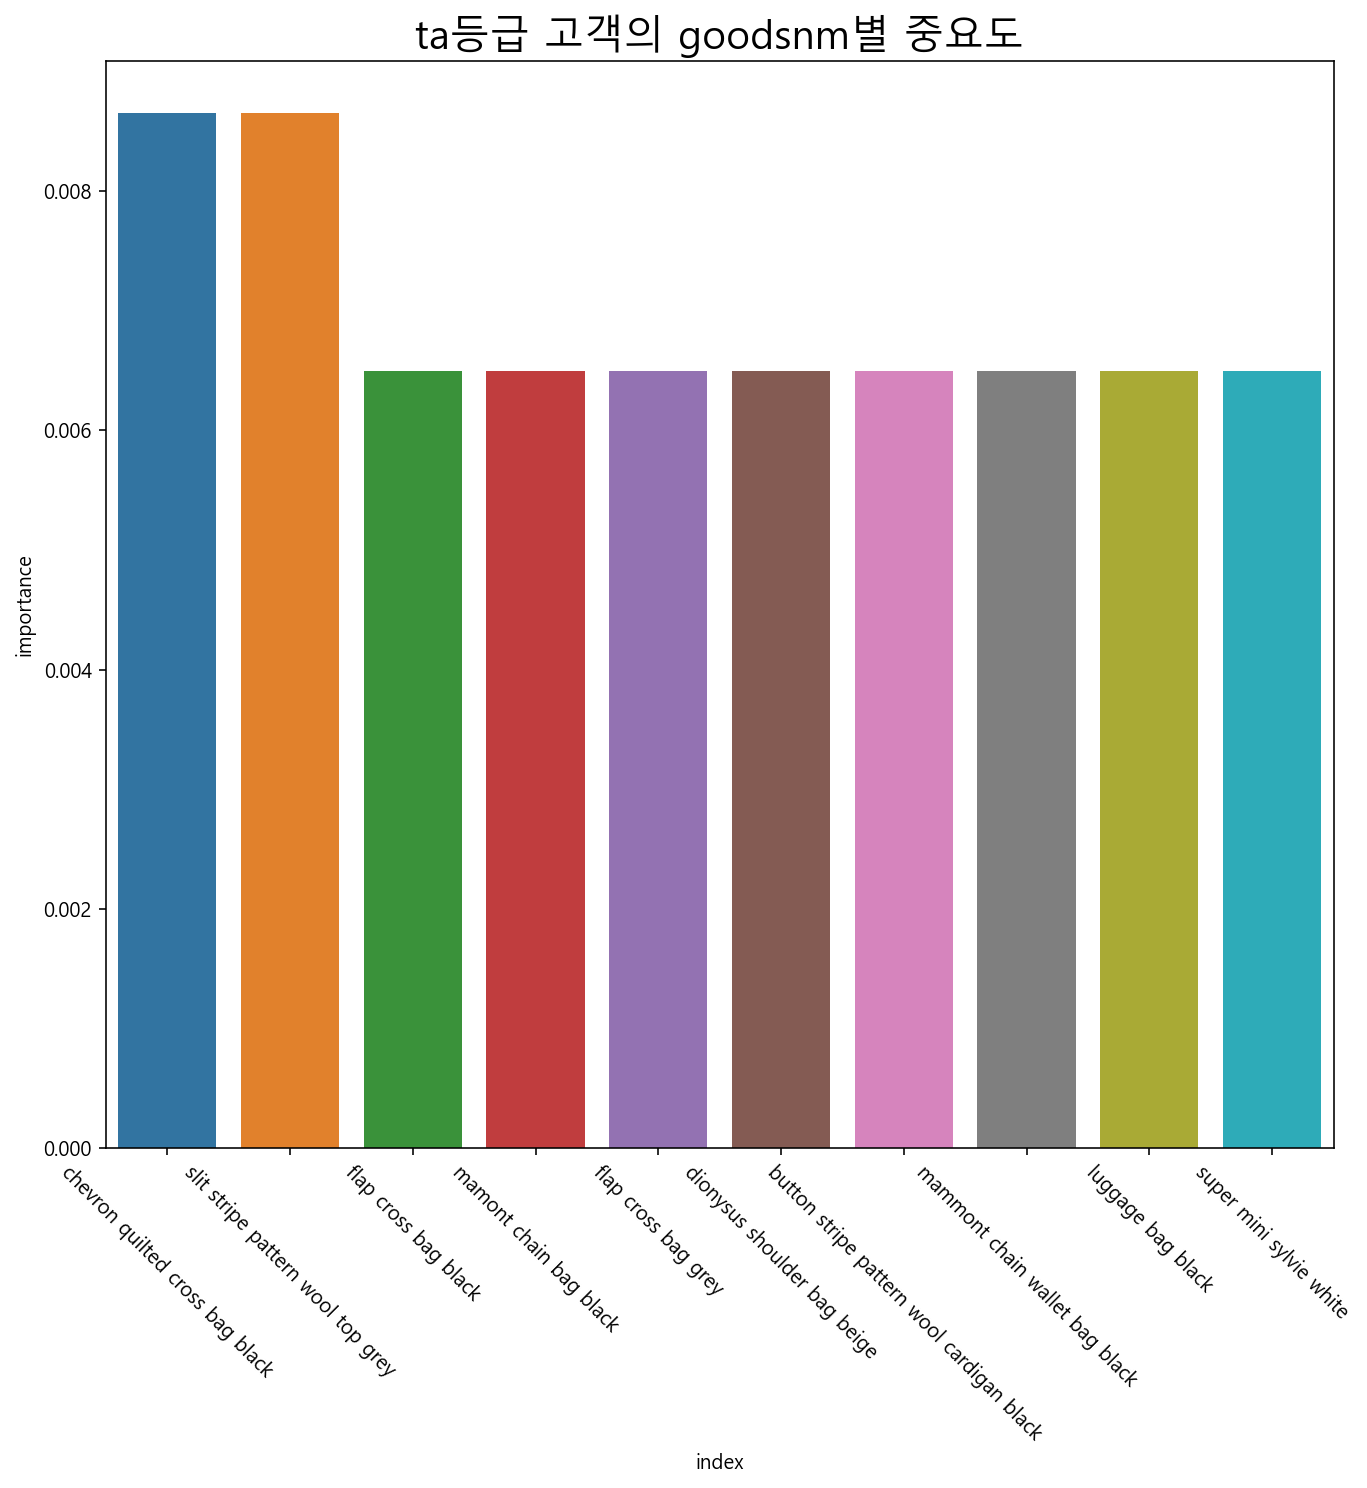

In [65]:
#ta goodsnm 분포 탐색 심화
df_ta2=pd.DataFrame(df_ta['goodsnm'].value_counts())
df_ta2.reset_index(inplace=True)
df_ta2['importance']=df_ta2['goodsnm']/df_ta2['goodsnm'].sum()
df_ta2=df_ta2.sort_values(by='importance',ascending=False).drop('goodsnm',axis=1)
df_ta2=df_ta2.head(10)
fig, ax = pyplot.subplots(figsize=(11,10))
plt.xticks(rotation = - 45 )
ax.set_title('ta등급 고객의 goodsnm별 중요도',fontsize=20)
sns.barplot(data=df_ta2,x='index',y= "importance")

<AxesSubplot:title={'center':'tb등급 고객의 goodsnm별 중요도'}, xlabel='index', ylabel='importbnce'>

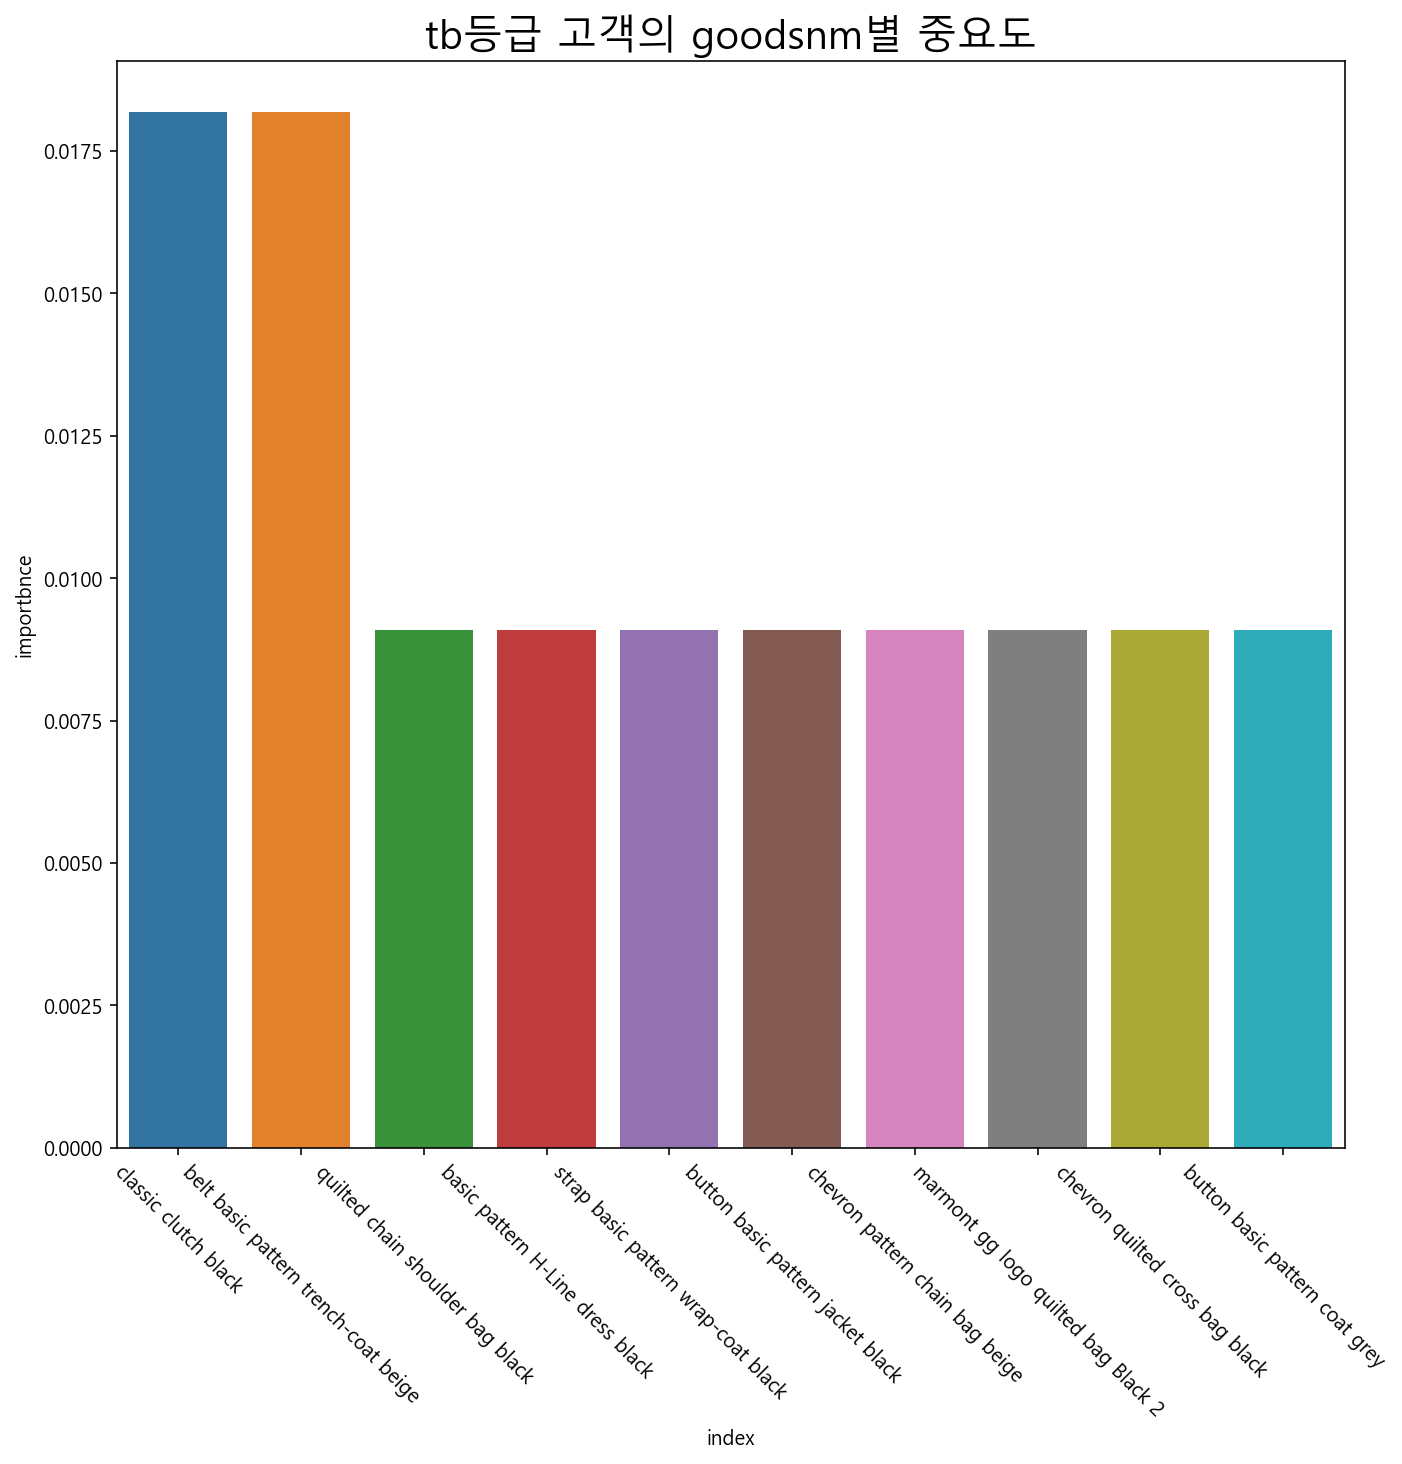

In [66]:
#tb goodsnm 분포 탐색 심화
df_tb2=pd.DataFrame(df_tb['goodsnm'].value_counts())
df_tb2.reset_index(inplace=True)
df_tb2['importbnce']=df_tb2['goodsnm']/df_tb2['goodsnm'].sum()
df_tb2=df_tb2.sort_values(by='importbnce',ascending=False).drop('goodsnm',axis=1)
df_tb2=df_tb2.head(10)
fig, ax = pyplot.subplots(figsize=(11,10))
plt.xticks(rotation = - 45 )
ax.set_title('tb등급 고객의 goodsnm별 중요도',fontsize=20)
sns.barplot(data=df_tb2,x='index',y= "importbnce")

<AxesSubplot:title={'center':'tc등급 고객의 goodsnm별 중요도'}, xlabel='index', ylabel='importcnce'>

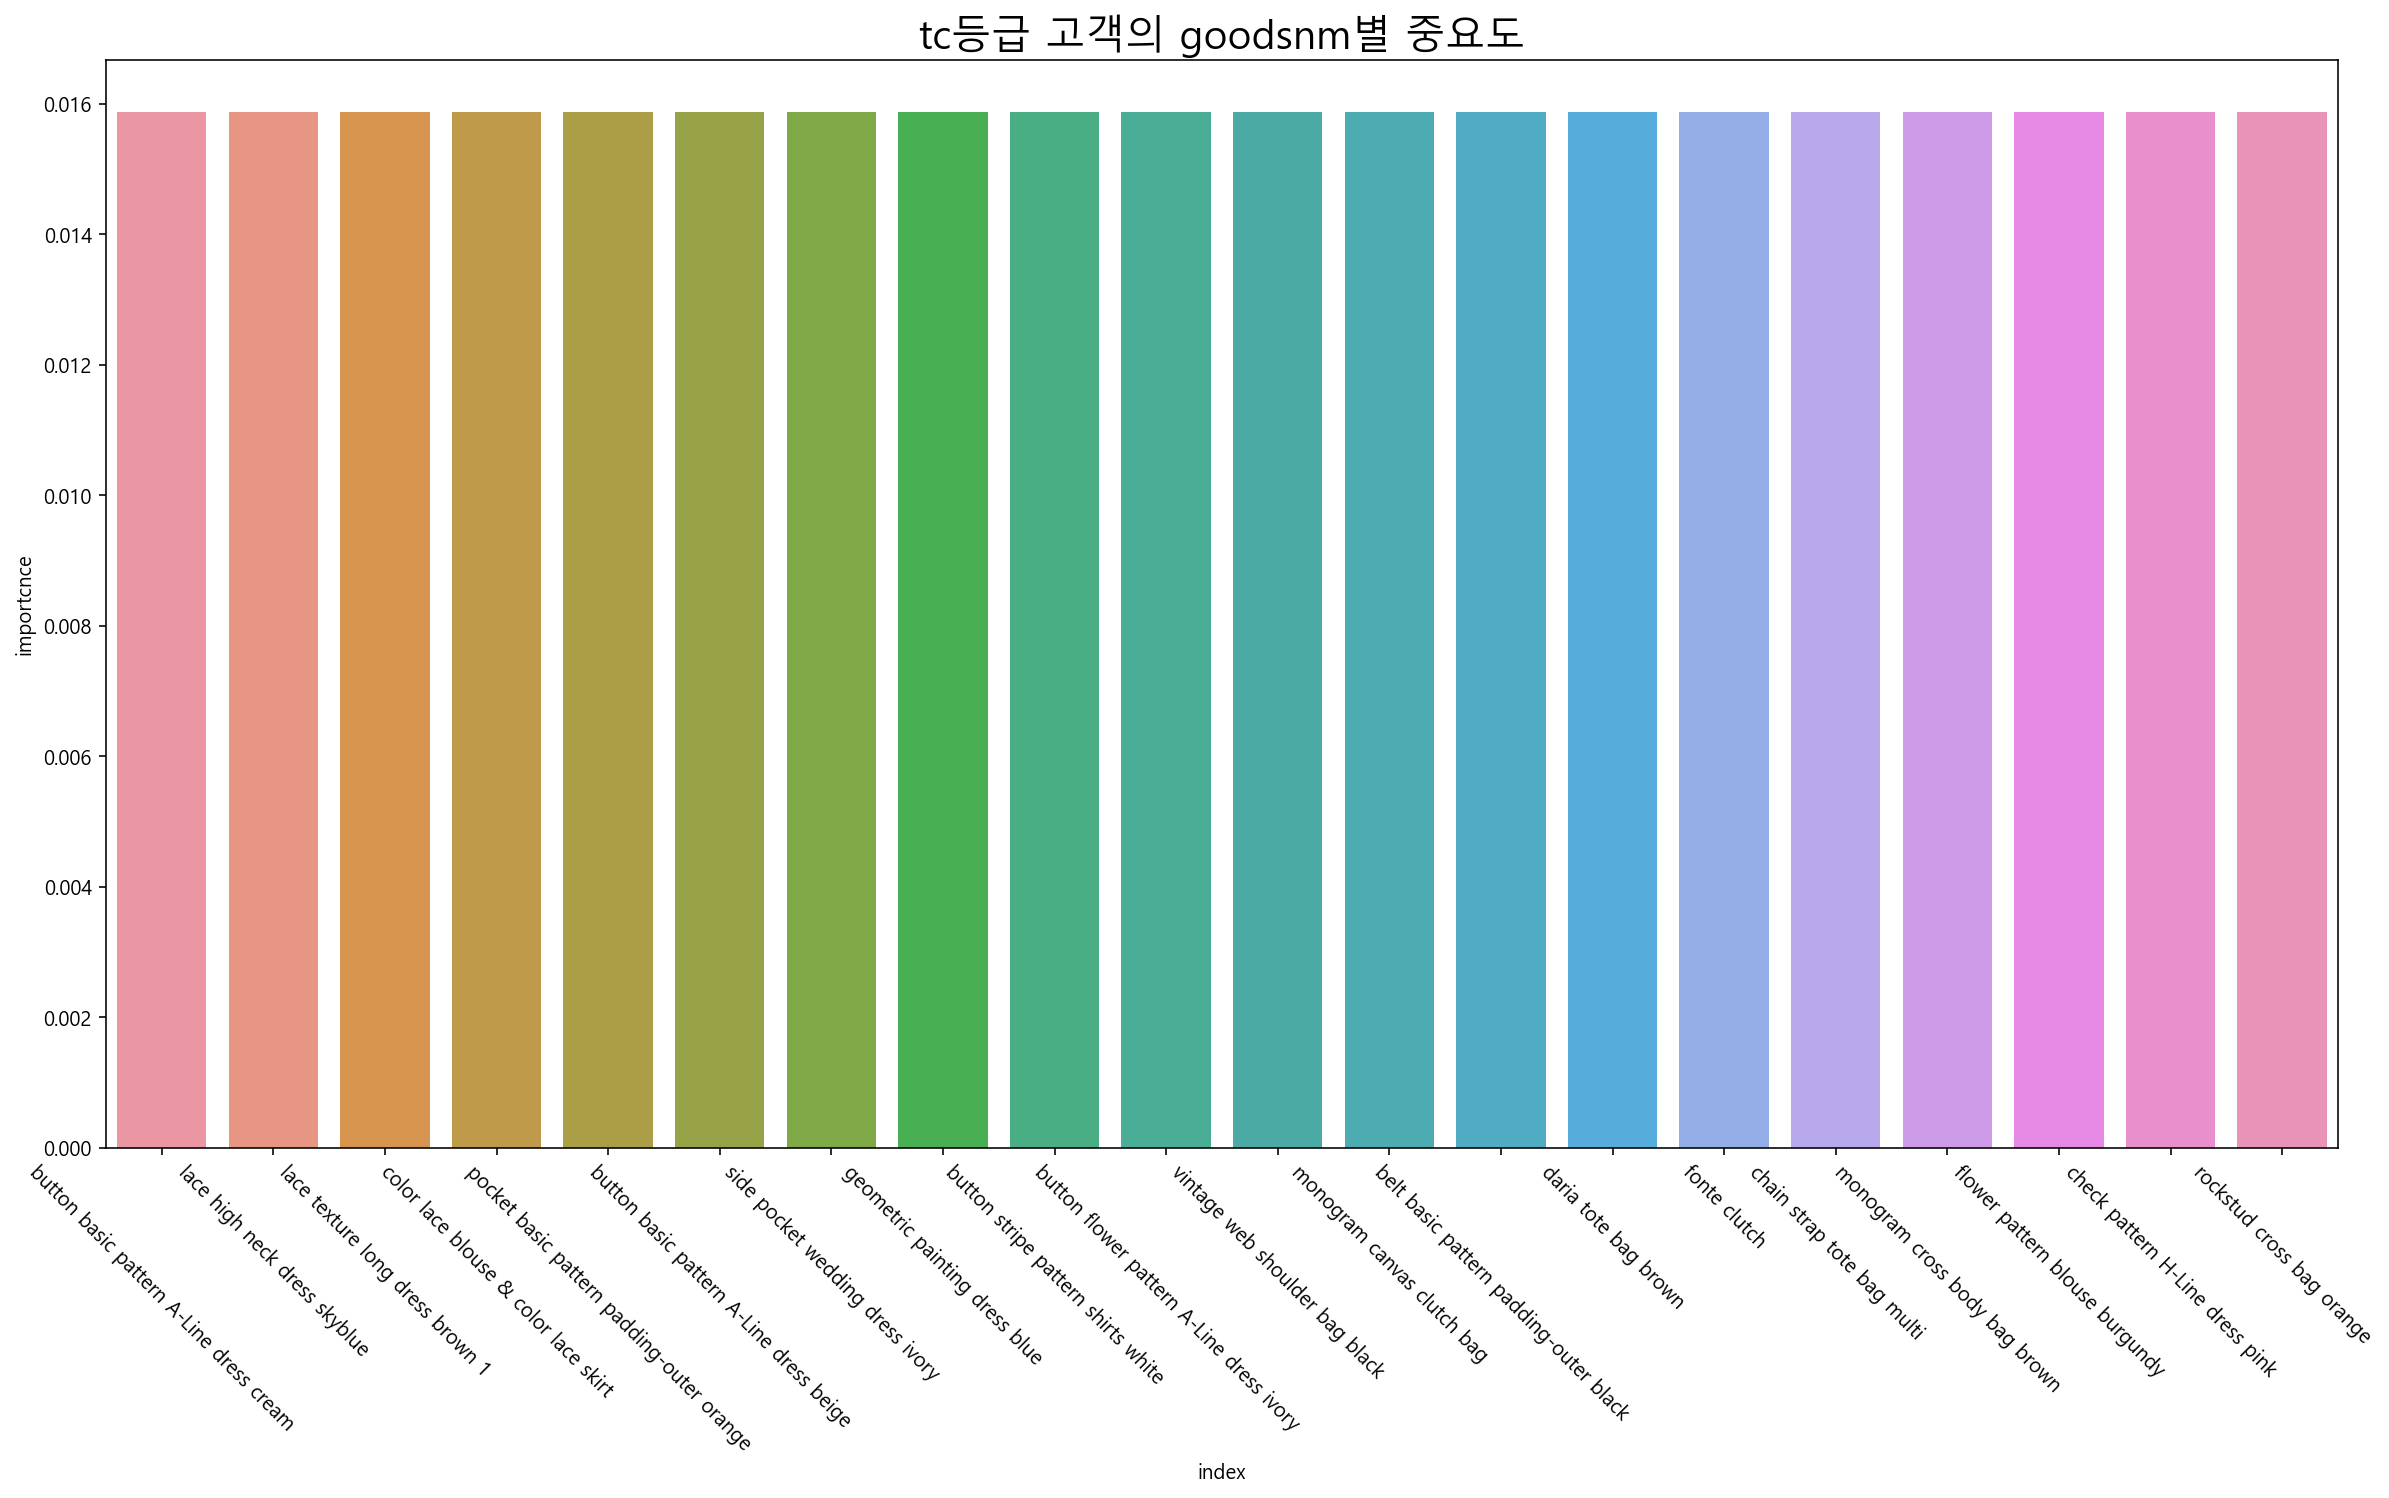

In [67]:
#tc goodsnm 분포 탐색 심화
df_tc2=pd.DataFrame(df_tc['goodsnm'].value_counts())
df_tc2.reset_index(inplace=True)
df_tc2['importcnce']=df_tc2['goodsnm']/df_tc2['goodsnm'].sum()
df_tc2=df_tc2.sort_values(by='importcnce',ascending=False).drop('goodsnm',axis=1)
df_tc2=df_tc2.head(20)
fig, ax = pyplot.subplots(figsize=(20,10))
plt.xticks(rotation = - 45 )
ax.set_title('tc등급 고객의 goodsnm별 중요도',fontsize=20)
sns.barplot(data=df_tc2,x='index',y= "importcnce")